In [1]:
%load_ext lab_black

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.layers as layers
import numpy as np
import dask.dataframe as dd
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action="ignore")

In [3]:
# reading data
data = dd.read_json("/home/sharoonsaxena/Datasets/Sarcasm.json").repartition(8)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
# creating train validation partition
train, validation = data.random_split([0.8, 0.2], shuffle=True)

In [5]:
# isolating headlines and labels
train_headline = train.headline.values.compute()
train_labels = train.is_sarcastic.values.compute()

val_headline = validation.headline.values.compute()
val_labels = validation.is_sarcastic.values.compute()

train_headline.shape, type(train_headline)

((21386,), numpy.ndarray)

In [6]:
# setting hyper-params
W_MAX_LEN = 200
W_VOCAB = 20000
OOV = "<OOV>"

# word tokenizer
word_tokenizer = Tokenizer(num_words=W_MAX_LEN, oov_token=OOV)
word_tokenizer.fit_on_texts(train_headline)
len(word_tokenizer.word_index)

26533

In [7]:
# setting hyper-params
C_MAX_LEN = 500
C_VOCAB = 150
EMBED_DIM = 32
PADDING = "post"
TRUNC = "post"

# word tokenizer
char_tokenizer = Tokenizer(
    num_words=C_MAX_LEN,
    oov_token=OOV,
    char_level=True,
)
char_tokenizer.fit_on_texts(train_headline)
len(char_tokenizer.word_index)

102

In [8]:
# texts to sequences using word tokenizer
train_word_sequences = word_tokenizer.texts_to_sequences(train_headline)
val_word_sequences = word_tokenizer.texts_to_sequences(val_headline)

len(train_word_sequences), type(train_word_sequences)

(21386, list)

In [9]:
# texts to sequences using char tokenizer
train_char_sequences = char_tokenizer.texts_to_sequences(train_headline)
val_char_sequences = char_tokenizer.texts_to_sequences(val_headline)

len(train_char_sequences), type(train_char_sequences)

(21386, list)

In [10]:
# padding word sequences
train_word_padded_sequences = pad_sequences(
    train_word_sequences, maxlen=W_MAX_LEN, padding=PADDING, truncating=TRUNC
)
val_word_padded_sequences = pad_sequences(
    val_word_sequences, maxlen=W_MAX_LEN, padding=PADDING, truncating=TRUNC
)

len(train_word_padded_sequences), type(train_word_padded_sequences)

(21386, numpy.ndarray)

In [11]:
# padding char sequences
train_char_padded_sequences = pad_sequences(
    train_char_sequences, maxlen=C_MAX_LEN, padding=PADDING, truncating=TRUNC
)
val_char_padded_sequences = pad_sequences(
    val_char_sequences, maxlen=C_MAX_LEN, padding=PADDING, truncating=TRUNC
)

len(train_char_padded_sequences), type(train_char_padded_sequences)

(21386, numpy.ndarray)

In [12]:
reverse_word_index = dict(
    [(value, key) for (key, value) in word_tokenizer.word_index.items()]
)


def decode_word_sentence(text):
    return " ".join([reverse_word_index.get(i, "") for i in text])


print(decode_word_sentence(train_word_padded_sequences[1]))
print(train_headline[1])

how to <OOV> to the <OOV> state obama <OOV> <OOV> <OOV> <OOV> to <OOV> <OOV> on <OOV> in <OOV>                                                                                                                                                                                     
how to lose to the islamic state: obama administration considers deploying troops to iraq, focusing on assad in syria


In [13]:
reverse_char_index = dict(
    [(value, key) for (key, value) in char_tokenizer.word_index.items()]
)


def decode_char_sentence(text):
    return "".join([reverse_char_index.get(i, "") for i in text])


print(decode_char_sentence(train_char_padded_sequences[1]))
print(train_headline[1])

how to lose to the islamic state: obama administration considers deploying troops to iraq, focusing on assad in syria
how to lose to the islamic state: obama administration considers deploying troops to iraq, focusing on assad in syria


In [14]:
# converting everything to list
train_word_padded_sequences.tolist(), train_labels.tolist()
val_word_padded_sequences.tolist(), val_labels.tolist()

train_char_padded_sequences.tolist()
val_char_padded_sequences.tolist()
print("done")

done


## About Batch size
* Larger Batch means stable/Faster training, Epochs are faster: (good when GPU used, maximises Compute utilisation)
* Smaller Batch means faster but noisy updates, Epochs are slower: (good for rapid start, mediocre compute utilisation)

<img src="https://raw.githubusercontent.com/SharoonSaxena/repo-image-hosting/main/Screenshot%20from%202021-06-27%2008-20-16.png">

* **Ideal Condition:**
    * Start with low batch, provides faster updates
    * Increase batch when plateu reached, stable updates = reaching convergeance
    
    
    
* **Effects on RAM:**
  * **Small Batch:** Less RAM required, RAM speed matters a lot because of movement
  * **Large Batch:** More RAM required, RAM speed is less important since Movement is less
  
  
  
* **Compute Utilisation:**
    * **Small batch:** Compute utilisation depends upon RAM speed, Compute utilisation is mediocre because of movement more than computation
    * **Large Batch:** More Compute utilisation, since movement is low and whole data is is within RAM

### Model 1: embedding model at word and character level

In [15]:
word_embed_model = Sequential(
    [
        layers.Embedding(
            input_dim=W_VOCAB,
            output_dim=EMBED_DIM,
            input_length=W_MAX_LEN,
        ),
        layers.Flatten(),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

word_embed_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
word_embed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           640000    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                102416    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 742,433
Trainable params: 742,433
Non-trainable params: 0
_________________________________________________________________


In [16]:
EPOCHS = 50
BATCH_SIZE = 64

history_word_embeds = word_embed_model.fit(
    x=train_word_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_word_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 3s 8ms/step - loss: 0.5265 - accuracy: 0.7170 - val_loss: 0.4365 - val_accuracy: 0.7813
Epoch 2/50
335/335 [==============================] - 2s 7ms/step - loss: 0.4230 - accuracy: 0.7943 - val_loss: 0.4341 - val_accuracy: 0.7845
Epoch 3/50
335/335 [==============================] - 2s 7ms/step - loss: 0.4115 - accuracy: 0.8013 - val_loss: 0.4208 - val_accuracy: 0.7990
Epoch 4/50
335/335 [==============================] - 3s 8ms/step - loss: 0.4015 - accuracy: 0.8066 - val_loss: 0.4536 - val_accuracy: 0.7644
Epoch 5/50
335/335 [==============================] - 2s 7ms/step - loss: 0.3979 - accuracy: 0.8067 - val_loss: 0.4227 - val_accuracy: 0.7997
Epoch 6/50
335/335 [==============================] - 2s 7ms/step - loss: 0.3914 - accuracy: 0.8108 - val_loss: 0.4204 - val_accuracy: 0.7999
Epoch 7/50
335/335 [==============================] - 2s 7ms/step - loss: 0.3837 - accuracy: 0.8153 - val_loss: 0.4229 - val_accuracy: 0.7982
Epoch 

In [17]:
char_embed_model = Sequential(
    [
        layers.Embedding(
            input_dim=C_VOCAB,
            output_dim=EMBED_DIM,
            input_length=C_MAX_LEN,
        ),
        layers.Flatten(),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

char_embed_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
char_embed_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           4800      
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                256016    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 260,833
Trainable params: 260,833
Non-trainable params: 0
_________________________________________________________________


In [18]:
history_char_embeds = char_embed_model.fit(
    x=train_char_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_char_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 2s 5ms/step - loss: 0.6199 - accuracy: 0.6430 - val_loss: 0.5723 - val_accuracy: 0.6987
Epoch 2/50
335/335 [==============================] - 2s 5ms/step - loss: 0.5304 - accuracy: 0.7267 - val_loss: 0.5422 - val_accuracy: 0.7158
Epoch 3/50
335/335 [==============================] - 2s 5ms/step - loss: 0.5022 - accuracy: 0.7487 - val_loss: 0.5359 - val_accuracy: 0.7201
Epoch 4/50
335/335 [==============================] - 2s 5ms/step - loss: 0.4824 - accuracy: 0.7598 - val_loss: 0.5267 - val_accuracy: 0.7314
Epoch 5/50
335/335 [==============================] - 2s 5ms/step - loss: 0.4567 - accuracy: 0.7770 - val_loss: 0.5321 - val_accuracy: 0.7314
Epoch 6/50
335/335 [==============================] - 2s 5ms/step - loss: 0.4270 - accuracy: 0.7946 - val_loss: 0.5342 - val_accuracy: 0.7300
Epoch 7/50
335/335 [==============================] - 2s 5ms/step - loss: 0.3906 - accuracy: 0.8193 - val_loss: 0.5506 - val_accuracy: 0.7265
Epoch 

In [19]:
history = []
history.append([history_word_embeds, history_char_embeds, "simple embedding model"])

### Model 2: GRU at character and Word tokens

In [20]:
word_GRU_model = Sequential(
    [
        layers.Embedding(
            input_dim=W_VOCAB,
            output_dim=EMBED_DIM,
            input_length=W_MAX_LEN,
        ),
        layers.Bidirectional(layers.GRU(8, return_sequences=True)),
        layers.Bidirectional(layers.GRU(8)),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

word_GRU_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
word_GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 16)           2016      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1248      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 643,553
Trainable params: 643,553
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_word_GRU = word_GRU_model.fit(
    x=train_word_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_word_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 61s 168ms/step - loss: 0.5176 - accuracy: 0.7244 - val_loss: 0.4555 - val_accuracy: 0.7731
Epoch 2/50
335/335 [==============================] - 55s 165ms/step - loss: 0.4492 - accuracy: 0.7756 - val_loss: 0.4409 - val_accuracy: 0.7834
Epoch 3/50
335/335 [==============================] - 54s 161ms/step - loss: 0.4353 - accuracy: 0.7843 - val_loss: 0.4310 - val_accuracy: 0.7900
Epoch 4/50
335/335 [==============================] - 54s 160ms/step - loss: 0.4250 - accuracy: 0.7903 - val_loss: 0.4294 - val_accuracy: 0.7881
Epoch 5/50
335/335 [==============================] - 58s 174ms/step - loss: 0.4197 - accuracy: 0.7943 - val_loss: 0.4243 - val_accuracy: 0.7958
Epoch 6/50
335/335 [==============================] - 53s 158ms/step - loss: 0.4119 - accuracy: 0.7973 - val_loss: 0.4296 - val_accuracy: 0.7920
Epoch 7/50
335/335 [==============================] - 54s 161ms/step - loss: 0.4062 - accuracy: 0.8002 - val_loss: 0.4216 - val_ac

In [22]:
char_GRU_model = Sequential(
    [
        layers.Embedding(
            input_dim=C_VOCAB,
            output_dim=EMBED_DIM,
            input_length=C_MAX_LEN,
        ),
        layers.Bidirectional(layers.GRU(units=8, return_sequences=True)),
        layers.Bidirectional(layers.GRU(units=8)),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

char_GRU_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
char_GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           4800      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 16)           2016      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16)                1248      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 8,353
Trainable params: 8,353
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_char_GRU = char_GRU_model.fit(
    x=train_char_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_char_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 135s 389ms/step - loss: 0.6257 - accuracy: 0.6122 - val_loss: 0.6025 - val_accuracy: 0.6476
Epoch 2/50
335/335 [==============================] - 129s 385ms/step - loss: 0.5958 - accuracy: 0.6363 - val_loss: 0.5937 - val_accuracy: 0.6545
Epoch 3/50
335/335 [==============================] - 129s 385ms/step - loss: 0.5863 - accuracy: 0.6467 - val_loss: 0.5874 - val_accuracy: 0.6525
Epoch 4/50
335/335 [==============================] - 129s 385ms/step - loss: 0.5688 - accuracy: 0.6753 - val_loss: 0.5617 - val_accuracy: 0.6919
Epoch 5/50
335/335 [==============================] - 129s 386ms/step - loss: 0.5325 - accuracy: 0.7221 - val_loss: 0.5403 - val_accuracy: 0.7206
Epoch 6/50
335/335 [==============================] - 129s 385ms/step - loss: 0.5095 - accuracy: 0.7387 - val_loss: 0.5160 - val_accuracy: 0.7372
Epoch 7/50
335/335 [==============================] - 129s 385ms/step - loss: 0.4990 - accuracy: 0.7464 - val_loss: 0.5055 -

In [24]:
history.append([history_word_GRU, history_char_GRU, "GRU Model"])

### Model 3: RNN based model with character and word level tokenisation

In [25]:
word_RNN_model = Sequential(
    [
        layers.Embedding(
            input_dim=W_VOCAB,
            output_dim=EMBED_DIM,
            input_length=W_MAX_LEN,
        ),
        layers.Bidirectional(layers.SimpleRNN(8, return_sequences=True)),
        layers.Bidirectional(layers.SimpleRNN(8)),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

word_RNN_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
word_RNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           640000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 16)           656       
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16)                400       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 641,345
Trainable params: 641,345
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_word_RNN = word_RNN_model.fit(
    x=train_word_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_word_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 39s 109ms/step - loss: 0.5316 - accuracy: 0.7157 - val_loss: 0.4367 - val_accuracy: 0.7892
Epoch 2/50
335/335 [==============================] - 36s 107ms/step - loss: 0.4249 - accuracy: 0.7931 - val_loss: 0.4323 - val_accuracy: 0.7832
Epoch 3/50
335/335 [==============================] - 36s 107ms/step - loss: 0.4074 - accuracy: 0.8025 - val_loss: 0.4310 - val_accuracy: 0.7887
Epoch 4/50
335/335 [==============================] - 36s 107ms/step - loss: 0.3970 - accuracy: 0.8069 - val_loss: 0.4297 - val_accuracy: 0.7905
Epoch 5/50
335/335 [==============================] - 36s 107ms/step - loss: 0.3882 - accuracy: 0.8122 - val_loss: 0.4410 - val_accuracy: 0.7819
Epoch 6/50
335/335 [==============================] - 36s 107ms/step - loss: 0.3859 - accuracy: 0.8152 - val_loss: 0.4354 - val_accuracy: 0.7825
Epoch 7/50
335/335 [==============================] - 36s 107ms/step - loss: 0.3771 - accuracy: 0.8198 - val_loss: 0.4346 - val_ac

In [27]:
char_RNN_model = Sequential(
    [
        layers.Embedding(
            input_dim=C_VOCAB,
            output_dim=EMBED_DIM,
            input_length=C_MAX_LEN,
        ),
        layers.Bidirectional(layers.SimpleRNN(units=8, return_sequences=True)),
        layers.Bidirectional(layers.SimpleRNN(units=8)),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

char_RNN_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
char_RNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           4800      
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 16)           656       
_________________________________________________________________
bidirectional_7 (Bidirection (None, 16)                400       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


In [28]:
history_char_RNN = char_RNN_model.fit(
    x=train_char_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_char_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 89s 260ms/step - loss: 0.6258 - accuracy: 0.6136 - val_loss: 0.5998 - val_accuracy: 0.6506
Epoch 2/50
335/335 [==============================] - 87s 258ms/step - loss: 0.5819 - accuracy: 0.6697 - val_loss: 0.5668 - val_accuracy: 0.6936
Epoch 3/50
335/335 [==============================] - 86s 257ms/step - loss: 0.5497 - accuracy: 0.7006 - val_loss: 0.5494 - val_accuracy: 0.7098
Epoch 4/50
335/335 [==============================] - 85s 254ms/step - loss: 0.5284 - accuracy: 0.7227 - val_loss: 0.5288 - val_accuracy: 0.7240
Epoch 5/50
335/335 [==============================] - 86s 255ms/step - loss: 0.5187 - accuracy: 0.7298 - val_loss: 0.5297 - val_accuracy: 0.7210
Epoch 6/50
335/335 [==============================] - 86s 257ms/step - loss: 0.5119 - accuracy: 0.7374 - val_loss: 0.5231 - val_accuracy: 0.7310
Epoch 7/50
335/335 [==============================] - 86s 257ms/step - loss: 0.5025 - accuracy: 0.7434 - val_loss: 0.5205 - val_ac

In [29]:
history.append([history_word_RNN, history_char_RNN, "RNN Model"])

### Model 4: Word and Character level with LSTM

In [30]:
word_LSTM_model = Sequential(
    [
        layers.Embedding(
            input_dim=W_VOCAB,
            output_dim=EMBED_DIM,
            input_length=W_MAX_LEN,
        ),
        layers.Bidirectional(layers.LSTM(8, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(8)),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

word_LSTM_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
word_LSTM_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 32)           640000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200, 16)           2624      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 16)                1600      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 644,513
Trainable params: 644,513
Non-trainable params: 0
_________________________________________________________________


In [31]:
history_word_LSTM = word_RNN_model.fit(
    x=train_word_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_word_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 37s 110ms/step - loss: 0.2861 - accuracy: 0.8711 - val_loss: 0.5719 - val_accuracy: 0.7539
Epoch 2/50
335/335 [==============================] - 37s 110ms/step - loss: 0.2868 - accuracy: 0.8693 - val_loss: 0.5738 - val_accuracy: 0.7625
Epoch 3/50
335/335 [==============================] - 37s 109ms/step - loss: 0.2850 - accuracy: 0.8684 - val_loss: 0.5787 - val_accuracy: 0.7543
Epoch 4/50
335/335 [==============================] - 37s 110ms/step - loss: 0.2843 - accuracy: 0.8707 - val_loss: 0.5657 - val_accuracy: 0.7629
Epoch 5/50
335/335 [==============================] - 37s 109ms/step - loss: 0.2834 - accuracy: 0.8731 - val_loss: 0.5652 - val_accuracy: 0.7633
Epoch 6/50
335/335 [==============================] - 37s 109ms/step - loss: 0.2853 - accuracy: 0.8704 - val_loss: 0.5649 - val_accuracy: 0.7635
Epoch 7/50
335/335 [==============================] - 37s 109ms/step - loss: 0.2825 - accuracy: 0.8732 - val_loss: 0.5682 - val_ac

In [32]:
char_LSTM_model = Sequential(
    [
        layers.Embedding(
            input_dim=C_VOCAB,
            output_dim=EMBED_DIM,
            input_length=C_MAX_LEN,
        ),
        layers.Bidirectional(layers.LSTM(units=8, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(units=8)),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

char_LSTM_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
char_LSTM_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           4800      
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 500, 16)           2624      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 16)                1600      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 9,313
Trainable params: 9,313
Non-trainable params: 0
_________________________________________________________________


In [33]:
history_char_LSTM = char_LSTM_model.fit(
    x=train_char_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_char_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 123s 355ms/step - loss: 0.6221 - accuracy: 0.6421 - val_loss: 0.6128 - val_accuracy: 0.6493
Epoch 2/50
335/335 [==============================] - 118s 352ms/step - loss: 0.5636 - accuracy: 0.7020 - val_loss: 0.5571 - val_accuracy: 0.7092
Epoch 3/50
335/335 [==============================] - 117s 351ms/step - loss: 0.5431 - accuracy: 0.7157 - val_loss: 0.5489 - val_accuracy: 0.7165
Epoch 4/50
335/335 [==============================] - 118s 351ms/step - loss: 0.5329 - accuracy: 0.7212 - val_loss: 0.5352 - val_accuracy: 0.7163
Epoch 5/50
335/335 [==============================] - 118s 352ms/step - loss: 0.5272 - accuracy: 0.7246 - val_loss: 0.5281 - val_accuracy: 0.7238
Epoch 6/50
335/335 [==============================] - 118s 352ms/step - loss: 0.5194 - accuracy: 0.7307 - val_loss: 0.5256 - val_accuracy: 0.7237
Epoch 7/50
335/335 [==============================] - 118s 351ms/step - loss: 0.5134 - accuracy: 0.7365 - val_loss: 0.5186 -

In [34]:
history.append([history_word_LSTM, history_char_LSTM, "LSTM Model"])

### Model 5 : Word and character level using Conv1D

In [35]:
word_CONV_model = Sequential(
    [
        layers.Embedding(
            input_dim=W_VOCAB,
            output_dim=EMBED_DIM,
            input_length=W_MAX_LEN,
        ),
        tf.keras.layers.Conv1D(128, 5, activation="relu"),
        tf.keras.layers.GlobalMaxPooling1D(),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

word_CONV_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
word_CONV_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 32)           640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          20608     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 662,689
Trainable params: 662,689
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_word_CONV = word_CONV_model.fit(
    x=train_word_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_word_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 8s 22ms/step - loss: 0.0974 - accuracy: 0.9525 - val_loss: 1.5792 - val_accuracy: 0.7558
Epoch 2/50
335/335 [==============================] - 8s 24ms/step - loss: 0.0948 - accuracy: 0.9519 - val_loss: 1.6287 - val_accuracy: 0.7424
Epoch 3/50
335/335 [==============================] - 8s 23ms/step - loss: 0.0942 - accuracy: 0.9516 - val_loss: 1.5755 - val_accuracy: 0.7462
Epoch 4/50
335/335 [==============================] - 8s 23ms/step - loss: 0.1025 - accuracy: 0.9494 - val_loss: 1.6040 - val_accuracy: 0.7458
Epoch 5/50
335/335 [==============================] - 8s 24ms/step - loss: 0.1001 - accuracy: 0.9495 - val_loss: 1.7089 - val_accuracy: 0.7563
Epoch 6/50
335/335 [==============================] - 8s 24ms/step - loss: 0.1003 - accuracy: 0.9506 - val_loss: 1.6328 - val_accuracy: 0.7515
Epoch 7/50
335/335 [==============================] - 8s 24ms/step - loss: 0.0997 - accuracy: 0.9503 - val_loss: 1.6544 - val_accuracy: 0.7558

In [42]:
char_CONV_model = Sequential(
    [
        layers.Embedding(
            input_dim=C_VOCAB,
            output_dim=EMBED_DIM,
            input_length=C_MAX_LEN,
        ),
        tf.keras.layers.Conv1D(128, 5, activation="relu"),
        tf.keras.layers.GlobalMaxPooling1D(),
        layers.Dense(units=16, activation="relu"),
        layers.Dense(units=1, activation="sigmoid"),
    ]
)

char_CONV_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
char_CONV_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 32)           4800      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 496, 128)          20608     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 27,489
Trainable params: 27,489
Non-trainable params: 0
_________________________________________________________________


In [43]:
history_char_CONV = char_CONV_model.fit(
    x=train_char_padded_sequences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_char_padded_sequences, val_labels),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
335/335 [==============================] - 17s 51ms/step - loss: 0.6040 - accuracy: 0.6578 - val_loss: 0.5165 - val_accuracy: 0.7500
Epoch 2/50
335/335 [==============================] - 17s 51ms/step - loss: 0.4887 - accuracy: 0.7678 - val_loss: 0.4631 - val_accuracy: 0.7849
Epoch 3/50
335/335 [==============================] - 17s 50ms/step - loss: 0.4342 - accuracy: 0.7981 - val_loss: 0.4380 - val_accuracy: 0.7949
Epoch 4/50
335/335 [==============================] - 17s 51ms/step - loss: 0.3956 - accuracy: 0.8203 - val_loss: 0.4141 - val_accuracy: 0.8001
Epoch 5/50
335/335 [==============================] - 17s 50ms/step - loss: 0.3580 - accuracy: 0.8427 - val_loss: 0.3993 - val_accuracy: 0.8136
Epoch 6/50
335/335 [==============================] - 17s 50ms/step - loss: 0.3332 - accuracy: 0.8549 - val_loss: 0.3930 - val_accuracy: 0.8133
Epoch 7/50
335/335 [==============================] - 17s 50ms/step - loss: 0.3044 - accuracy: 0.8730 - val_loss: 0.4554 - val_accuracy:

In [44]:
history.append([history_word_CONV, history_char_CONV, "Convolution model"])

In [45]:
def word_char_compare(word_history, char_history, model_name, epochs):
    plt.figure(figsize=(15, 5), dpi=150)
    plt.subplot(1, 2, 1)
    plt.plot(word_history.history["accuracy"], label="train_accuracy")
    plt.plot(word_history.history["val_accuracy"], label="validation_accuracy")
    plt.xlabel("Epochs")
    plt.title("{} (word tokens)".format(model_name))
    plt.ylabel("accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(char_history.history["accuracy"], label="train_accuracy")
    plt.plot(char_history.history["val_accuracy"], label="validation_accuracy")
    plt.xlabel("Epochs")
    plt.title("{} (character tokens)".format(model_name))
    plt.ylabel("accuracy")
    plt.legend()

    plt.show()

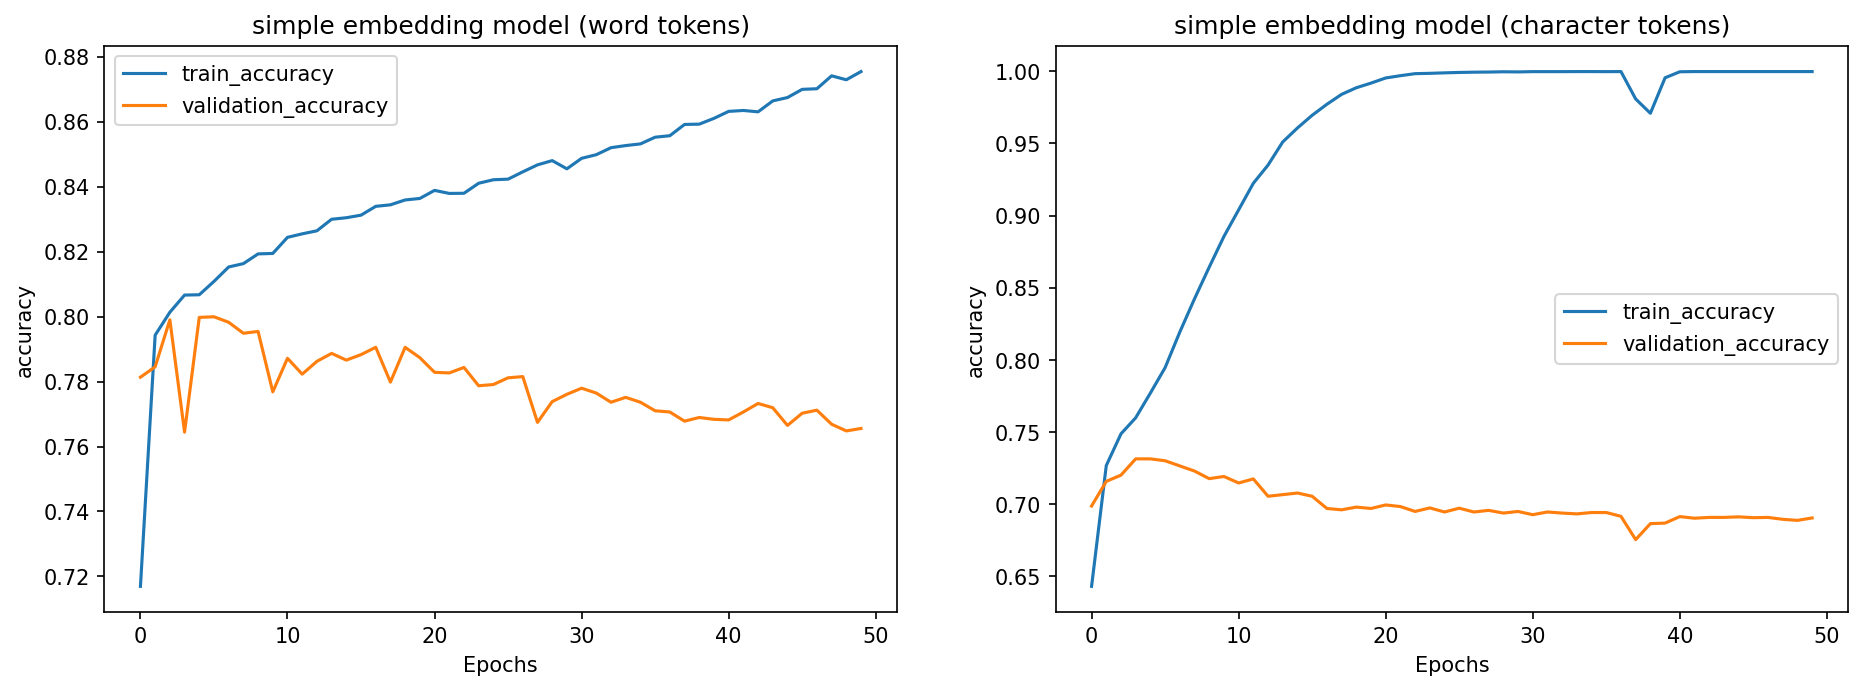

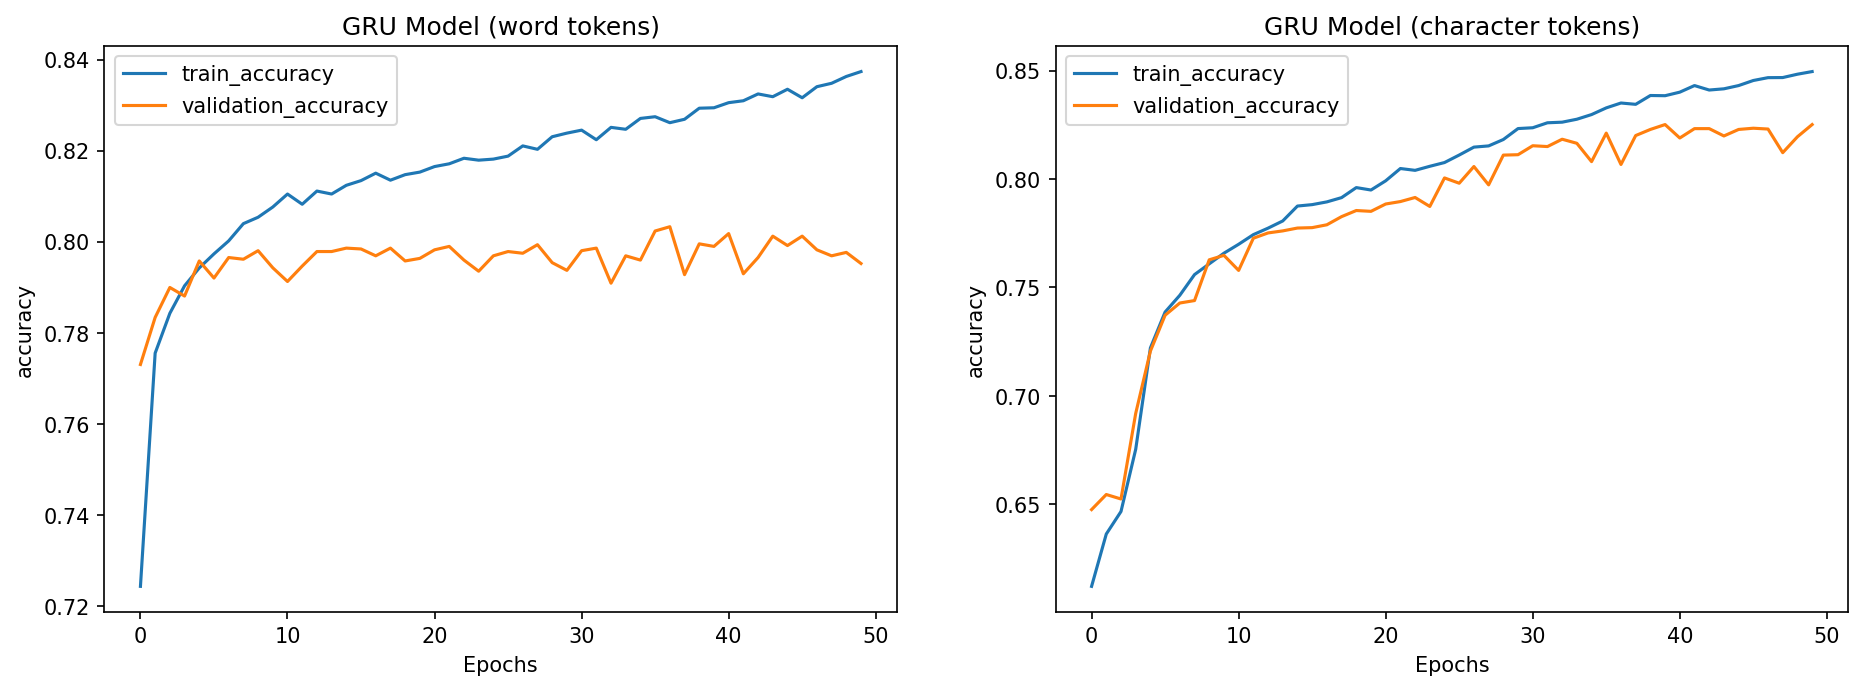

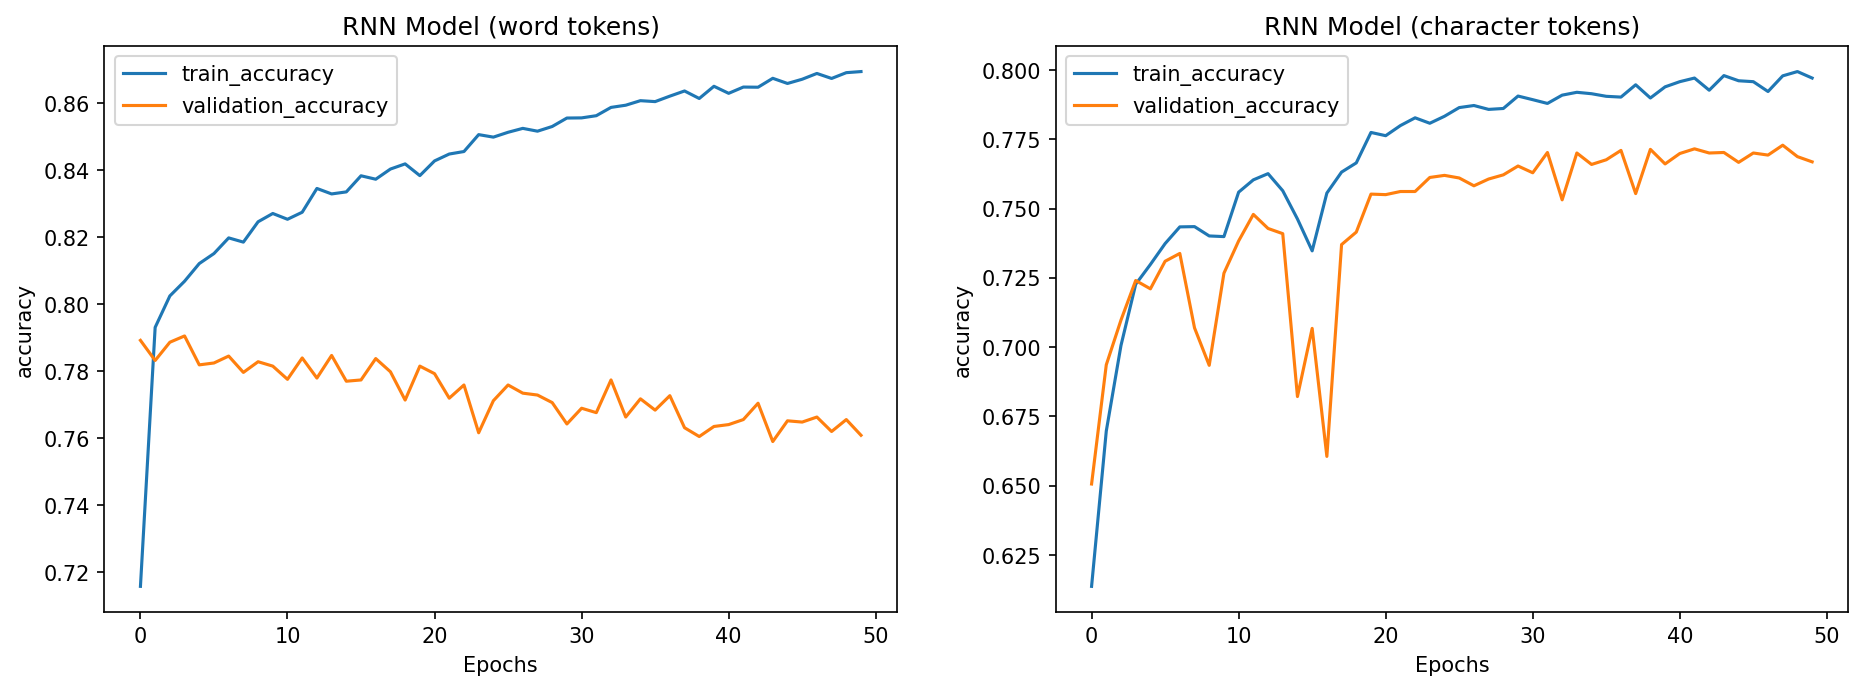

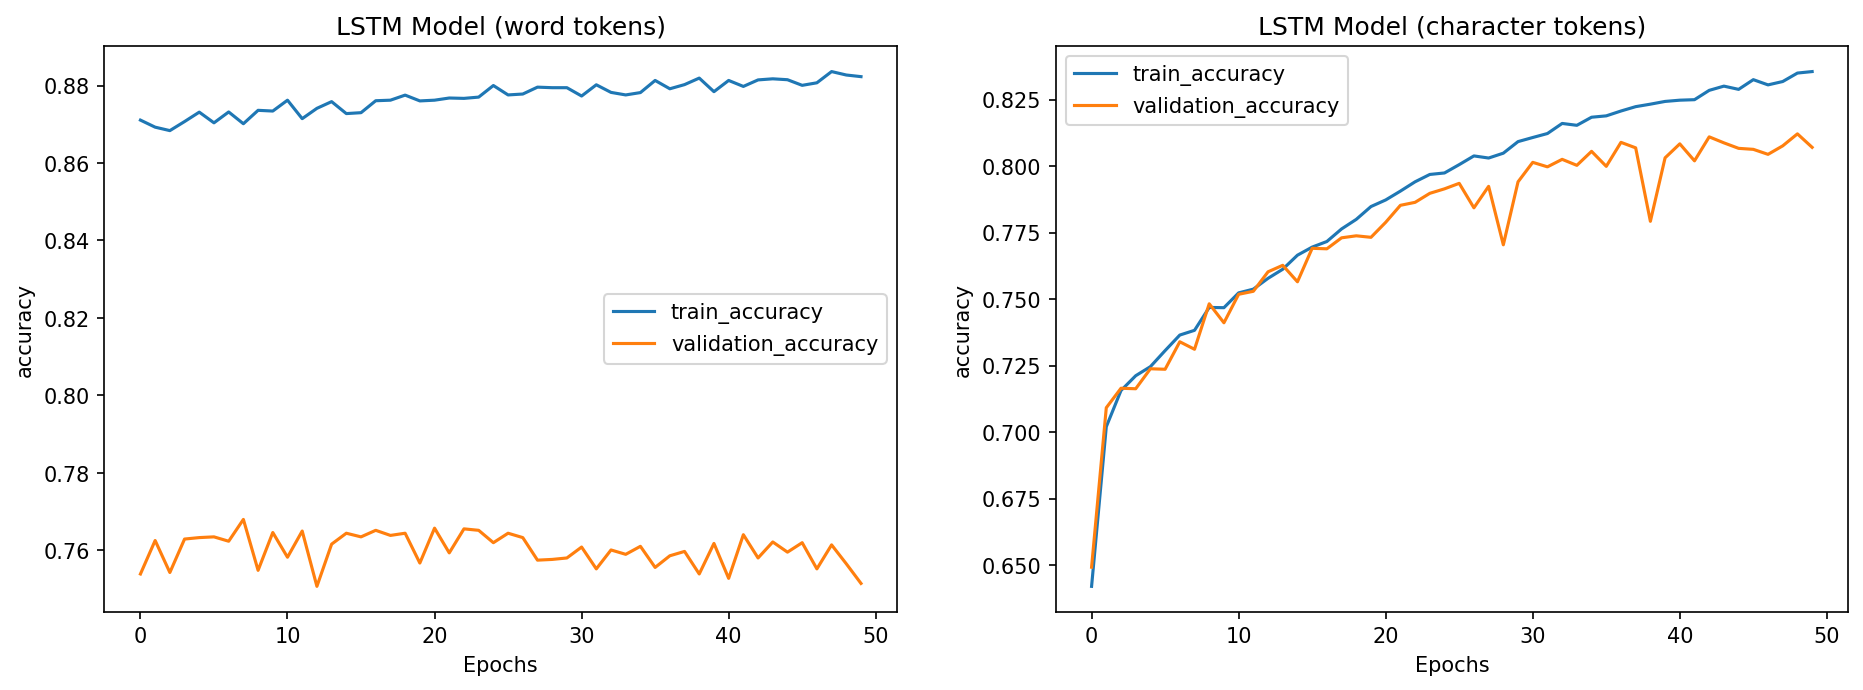

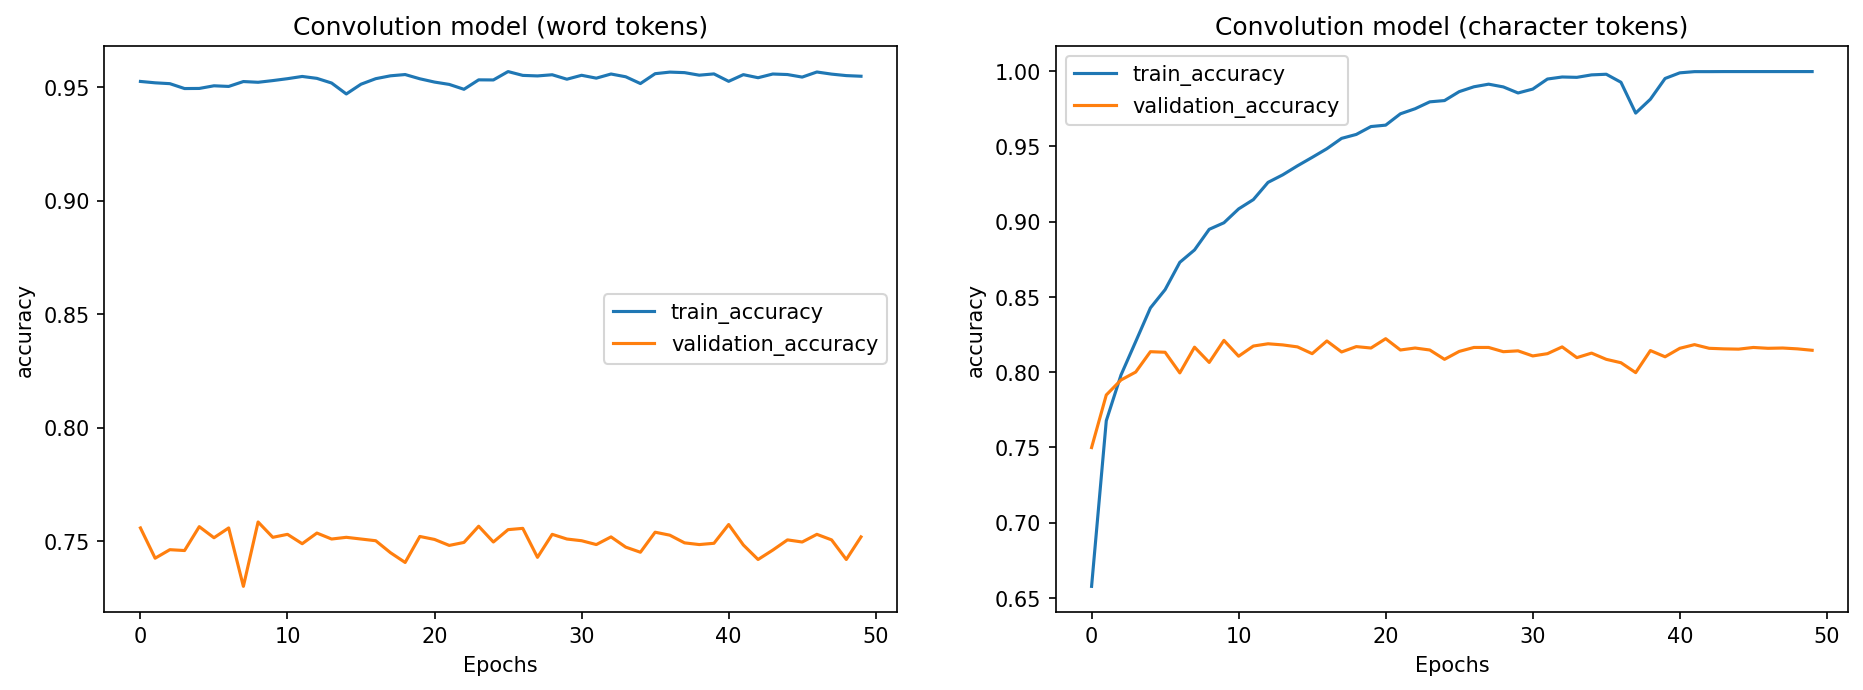

In [46]:
for i in history:
    word_char_compare(*i, EPOCHS)